# PLR 함수 구현

In [914]:
import numpy as np
from sklearn.linear_model import Lasso
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os 
%matplotlib inline


def connect_line(arr, span_tuple):
    '''
    Return function for a line that connects two values from arr.
    Inputs:
    - arr: numpy 1d-array of time-series values
    - span_tuple: start and enpdpoints for line
    '''
    first, last = span_tuple
    run = last - first
    rise = arr[last] - arr[first]
    slope = rise / run
    intercept = arr[first] - first * slope

    return lambda x: intercept + slope * x


def line_point_distance(arr, x1, x2, x0):
    '''
    Calculate the minimal orthogonal distance from a line connecting
    (x1, arr[x1]) and (x2, arr[x2]) to a third point (x0, arr[x0])
    Distance formula from https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line.
    
    Inputs:
    - arr: numpy 1d-array of time-series values
    - x1: int, start x-value of line
    - x2: int, end x-value of line
    - x3: int, third point for distance to be calculated
    '''
    y1 = arr[x1]
    y2 = arr[x2]
    y0 = arr[x0]

    numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)

    return numerator / denominator


def farthest_point(arr, x1, x2):
    '''
    Find the farthest point between two points that define a line on a time-series.
    '''
    xx = np.arange(len(arr))

    distances_partial = partial(line_point_distance, arr, x1, x2)
    distances = distances_partial(xx)
    mask = (xx > x1) & (xx < x2)
    farthest_point_indx = np.argmax(distances[mask]) + x1
    max_distance = distances[farthest_point_indx]

    return farthest_point_indx, max_distance


def flatten(nested):
    '''
    Utility to flatten nested lists.
    '''
    flattened = []
    for item in nested:
        if type(item) != list:
            flattened.append(item)
        else:
            flattened += flatten(item)
    return flattened


def plr_recursive(arr, span_tuple, epsilon):
    '''
    Compute piece-wise linear regression on a time series.
    Inputs:
    - arr: numpy 1d-array of time-series values
    - span_tuple: start and endpoints
    - epsilon: threshold for line-breaking
    Outputs:
    - lines: list of lambda functions
    - points: list of points that dicate when lambdas should be used
    '''
    first, last = span_tuple
    farthest_indx, distance = farthest_point(arr, first, last)

    lines = []
    points = []

    if distance < epsilon: #base case
        line = connect_line(arr, span_tuple)
        point = first

        return line, point

    else: #recursive case

        line_1, point_1 = plr_recursive(arr, (first, farthest_indx), epsilon)
        line_2, point_2 = plr_recursive(arr, (farthest_indx, last), epsilon)

        lines.extend([line_1, line_2])
        points.extend([point_1, point_2])

        #flatten out recursive nests
        return flatten(lines), flatten(points)


def PLR(arr, epsilon):
    '''
    Compute full PLR for a time series
    '''
    xx = np.arange(len(arr))
    lines, points = plr_recursive(arr, (0, len(arr) -1), epsilon)

    if type(lines) != list:
        plr_values = lines(xx)
        
    else:
        plr_values = np.piecewise(xx, [xx >= point for point in points], lines)

    return plr_values, lines, points

# signal trend 구현

In [915]:
def up_down_trend(arr, epsilon):
    '''
    Classify point in a time series as either in an up trend or a down trend
    as determined by a PLR.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - list of list of bools, where True indicates membership of an up trend
    '''
    pieces, lines, points = PLR(arr, epsilon)
    points.append(len(arr) - 1)
    diffs = np.diff(points)
    
    #I think this compensates for undercounting the first trend by one
    diffs[0] += 1 
    
    trend_labels = []
    
    for point, diff in zip(points[1:], diffs):
        up = [arr[point] - arr[point - 5] > 0]
        #print(up)
        #print(diff)
        #print(up * diff)
        trend_labels.append(up * diff)
    
    return trend_labels


def trading_signal(arr, epsilon):
    '''
    Convert a time-series into a trading signal ranging from 0 to 1.
    For more information refer to "A dynamic threshold decision system ..."
    by Chang et al.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - numpy 1d-array with the same length as arr
    '''
    labels = up_down_trend(arr, epsilon)
    
    
    final_signal_list = []
    trend_pos_list = []
    for trend_list in labels:
        up = any(trend_list)
        length = len(trend_list)
        half_length, remainder = divmod(length, 2)
        

        if remainder:
            half_length += 1
            
        if up:
            first_half = 0.5 - np.arange(half_length) / length
            #print(type(np.arange(half_length)))
            trend_half = np.ones(half_length)
        else:
            first_half = 0.5 + np.arange(half_length) / length
            #first_half = np.zeros(half_length)
            trend_half = np.zeros(half_length)
        
        if remainder:
            trend_signal = np.concatenate((first_half, first_half[-2::-1]))
            trend = np.concatenate((trend_half, trend_half[-2::-1]))
        else:
            trend_signal = np.concatenate((first_half, first_half[::-1]))
            trend = np.concatenate((trend_half, trend_half[::-1]))
        
        
        final_signal_list.append(trend_signal)
        trend_pos_list.append(trend)
       
    return np.concatenate(final_signal_list),np.concatenate(trend_pos_list)

In [916]:
from pandas_datareader import data
import talib

#apple = pd.read_csv('C:/Users/jangkoon.park/test.csv')
samsung = data.DataReader('005930.KS','yahoo', '1999-01-01') #Import historical stock data for training
#apple["Date"] = pd.to_datetime(apple["Date"])
#apple = apple.set_index("Date")
close = samsung["Close"].values



# PLR 그래프 확인

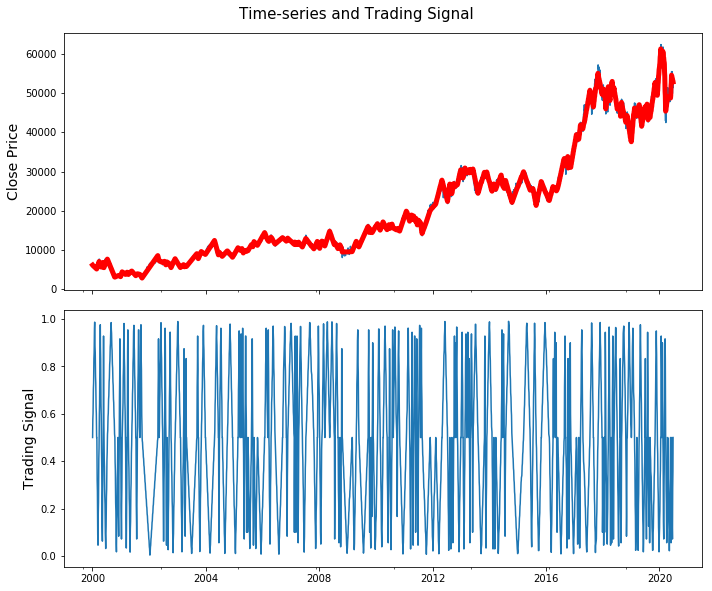

In [917]:


fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex= True, figsize = (10, 8))
fig.suptitle("Time-series and Trading Signal", y = 1.02, size = 15)
xx = np.arange(len(close))
#ax1.plot(piece, c = "red")
samsung["Close"].plot(ax = ax1 )
ax1.set_ylabel("Close Price", size = 14)

thresHold = 20
piece, lines, points = PLR(close, thresHold)

ax1.plot(samsung.index, piece, c = "red", linewidth = 5, label = "PLR (threshold 20)")

ts,tp= trading_signal(close, thresHold)


ax2.plot(samsung.index, ts)
ax2.set_ylabel("Trading Signal", size = 14)

plt.tight_layout()

# 데이터 세팅 

In [918]:
from sklearn import preprocessing, svm 

samsung['Target'] = ts
samsung['Target_position'] = tp
samsung['short_rolling'] = samsung['Close'].rolling(window=20).mean()
samsung['long_rolling'] = samsung['Close'].rolling(window=100).mean()
samsung['ema_short'] = samsung['Close'].ewm(span=20, adjust=False).mean()
samsung['RSI14'] = talib.RSI(np.array(samsung['Close'].astype(float)), timeperiod=14)
samsung['MACD'], samsung['MACD_SIGN'], samsung['MACD_HIST'] = talib.MACD(samsung['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
samsung["slowk"], samsung["slowd"] = talib.STOCH(samsung['High'], samsung['Low'], samsung['Close'], fastk_period=5, slowk_period=3, slowk_matype=0,
                                           slowd_period=3, slowd_matype=0)

samsung["WILLR"] = talib.WILLR(samsung['High'], samsung['Low'], samsung['Close'], timeperiod=14)


samsung.head()
#samsung.to_csv('C:/Users/jangkoon.park/samsung_data.csv')


samsung.dropna(inplace=True)
samsung.reset_index(level=0, inplace=True)
print(samsung)
#X_sep = np.array(samsung.drop(['Target'],1))


#X = preprocessing.scale(X_sep)
#Y = np.array(samsung['Target'])


#target 0이면 다운 1이면 업

#X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size=0.6, test_size=0.4, shuffle=False)

#print(samsung)

           Date     High      Low     Open    Close      Volume     Adj Close  \
0    2000-05-22   6830.0   6620.0   6720.0   6670.0  36385000.0      0.098903   
1    2000-05-23   6700.0   6350.0   6500.0   6380.0  41290000.0      0.094603   
2    2000-05-24   6370.0   5920.0   6160.0   6200.0  72150000.0      0.091934   
3    2000-05-25   6380.0   5930.0   6330.0   6000.0  85965000.0      0.088968   
4    2000-05-26   5990.0   5600.0   5900.0   5600.0  67100000.0      0.083037   
...         ...      ...      ...      ...      ...         ...           ...   
5036 2020-06-18  52300.0  51600.0  52200.0  52300.0  15982926.0  52300.000000   
5037 2020-06-19  52900.0  51600.0  52600.0  52900.0  18157985.0  52900.000000   
5038 2020-06-22  52600.0  51800.0  52000.0  52000.0  13801350.0  52000.000000   
5039 2020-06-23  52800.0  51100.0  52500.0  51400.0  18086152.0  51400.000000   
5040 2020-06-24  53900.0  51600.0  51900.0  52900.0  24247413.0  52900.000000   

        Target  Target_posi

In [919]:
samsung['Open-Close'] = samsung.Open - samsung.Close
samsung['High-Low'] = samsung.High - samsung.Low




# 데이터 인자 종류 (시작가-종가, 최상가-최하가,ema short,거래신호값)

In [929]:

x = samsung[['Open-Close','High-Low','ema_short','Target','short_rolling','long_rolling','RSI14','slowk','slowd','MACD','WILLR']]
y = samsung.Target_position

x


,Open-Close,High-Low,ema_short,Target,short_rolling,long_rolling,RSI14,slowk,slowd,MACD,WILLR
0,50.0,210.0,6469.125311,0.642857,6298.5,5938.0,55.257652,44.742894,59.136789,154.636388,-53.600000
1,120.0,350.0,6460.637186,0.785714,6335.5,5940.7,49.387966,27.673899,44.067637,127.625512,-80.000000
2,-40.0,450.0,6435.814597,0.928571,6365.5,5946.9,46.113717,16.077779,29.498191,90.649749,-80.281690
3,330.0,450.0,6394.308445,0.785714,6395.5,5950.7,42.724425,12.373165,18.708281,44.692672,-94.366197
4,300.0,390.0,6318.660021,0.642857,6375.5,5951.3,36.885311,11.363064,13.271336,-23.731734,-100.000000
...,...,...,...,...,...,...,...,...,...,...,...
5036,-100.0,700.0,52158.046643,0.214286,52197.5,52412.0,52.159301,53.632479,32.717949,685.012276,-66.197183
5037,-300.0,1300.0,52228.708867,0.285714,52405.0,52333.0,54.567914,74.743590,51.780627,662.975292,-57.746479
5038,0.0,800.0,52206.927070,0.357143,52562.5,52265.0,50.463748,80.289855,69.555308,566.359703,-70.422535
5039,1100.0,1700.0,52130.076873,0.428571,52670.0,52188.0,47.878391,59.178744,71.404063,436.346239,-78.873239


In [921]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train

,Open-Close,High-Low,ema_short,Target,short_rolling,long_rolling,RSI14,slowk,slowd,MACD,WILLR
463,250.0,260.0,6817.572221,0.272414,6812.5,5416.1,63.098539,73.767658,73.781274,231.330238,-29.761905
3688,240.0,500.0,25435.718157,0.130000,25212.0,24534.2,60.922654,45.586827,67.876077,688.159838,-29.714286
1270,-80.0,140.0,10229.487251,0.500000,10141.5,9576.2,59.356894,64.444444,74.444444,79.435521,-16.129032
2118,100.0,400.0,11312.563977,0.574074,11369.0,12917.0,32.582266,27.530864,27.530451,-252.504937,-84.705882
594,-70.0,130.0,6606.718408,0.184211,6636.0,6957.6,43.566599,9.620596,27.804018,-30.525857,-88.571429
3128,40.0,680.0,24995.891327,0.441176,25572.0,24928.4,44.924495,67.569069,54.718206,-137.924946,-75.274725
1361,-120.0,240.0,11196.676461,0.750000,11244.0,10174.8,64.373955,75.179676,85.389694,216.536850,-25.641026
625,20.0,210.0,6141.816081,0.337838,6042.0,6593.7,57.719531,88.947062,91.848912,-54.416955,-11.363636
450,-40.0,130.0,6423.641675,0.182759,6382.0,4916.0,64.230929,75.000000,80.987096,235.318348,-22.018349
4486,-500.0,1100.0,49470.914242,0.766667,48703.0,51016.0,61.192566,49.771994,62.735544,850.079973,-11.815562


# svm 모델 사용

In [922]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier().fit(X_train, y_train)

importances = model.feature_importances_

# Plot
importances

array([1.18386564e-03, 1.77318576e-03, 3.52066625e-04, 9.84522949e-01,
       8.44744099e-04, 1.21902462e-03, 2.37750993e-03, 3.99132115e-03,
       1.79026711e-03, 3.22532992e-04, 1.62253296e-03])

In [923]:
from sklearn.svm import SVC
cls = SVC().fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [924]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, cls.predict(X_train))
accuracy_test = accuracy_score(y_test, cls.predict(X_test))

In [925]:
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))

print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 100.00%
Test Accuracy: 57.78%


# knn 알고리즘 사용

In [926]:
from sklearn.neighbors import KNeighborsClassifier
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 1


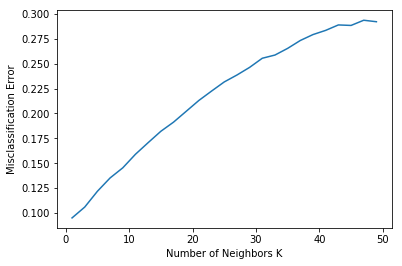

In [927]:
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [928]:

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
accuracy_train = accuracy_score(y_train, knn.predict(X_train))

accuracy_test = accuracy_score(y_test, knn.predict(X_test))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))

print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))



Train Accuracy: 100.00%
Test Accuracy: 91.87%


# up down 추세 데이터 분리

In [911]:
up = samsung[samsung['Target_position'] == 1]
down = samsung[samsung['Target_position'] == 0]


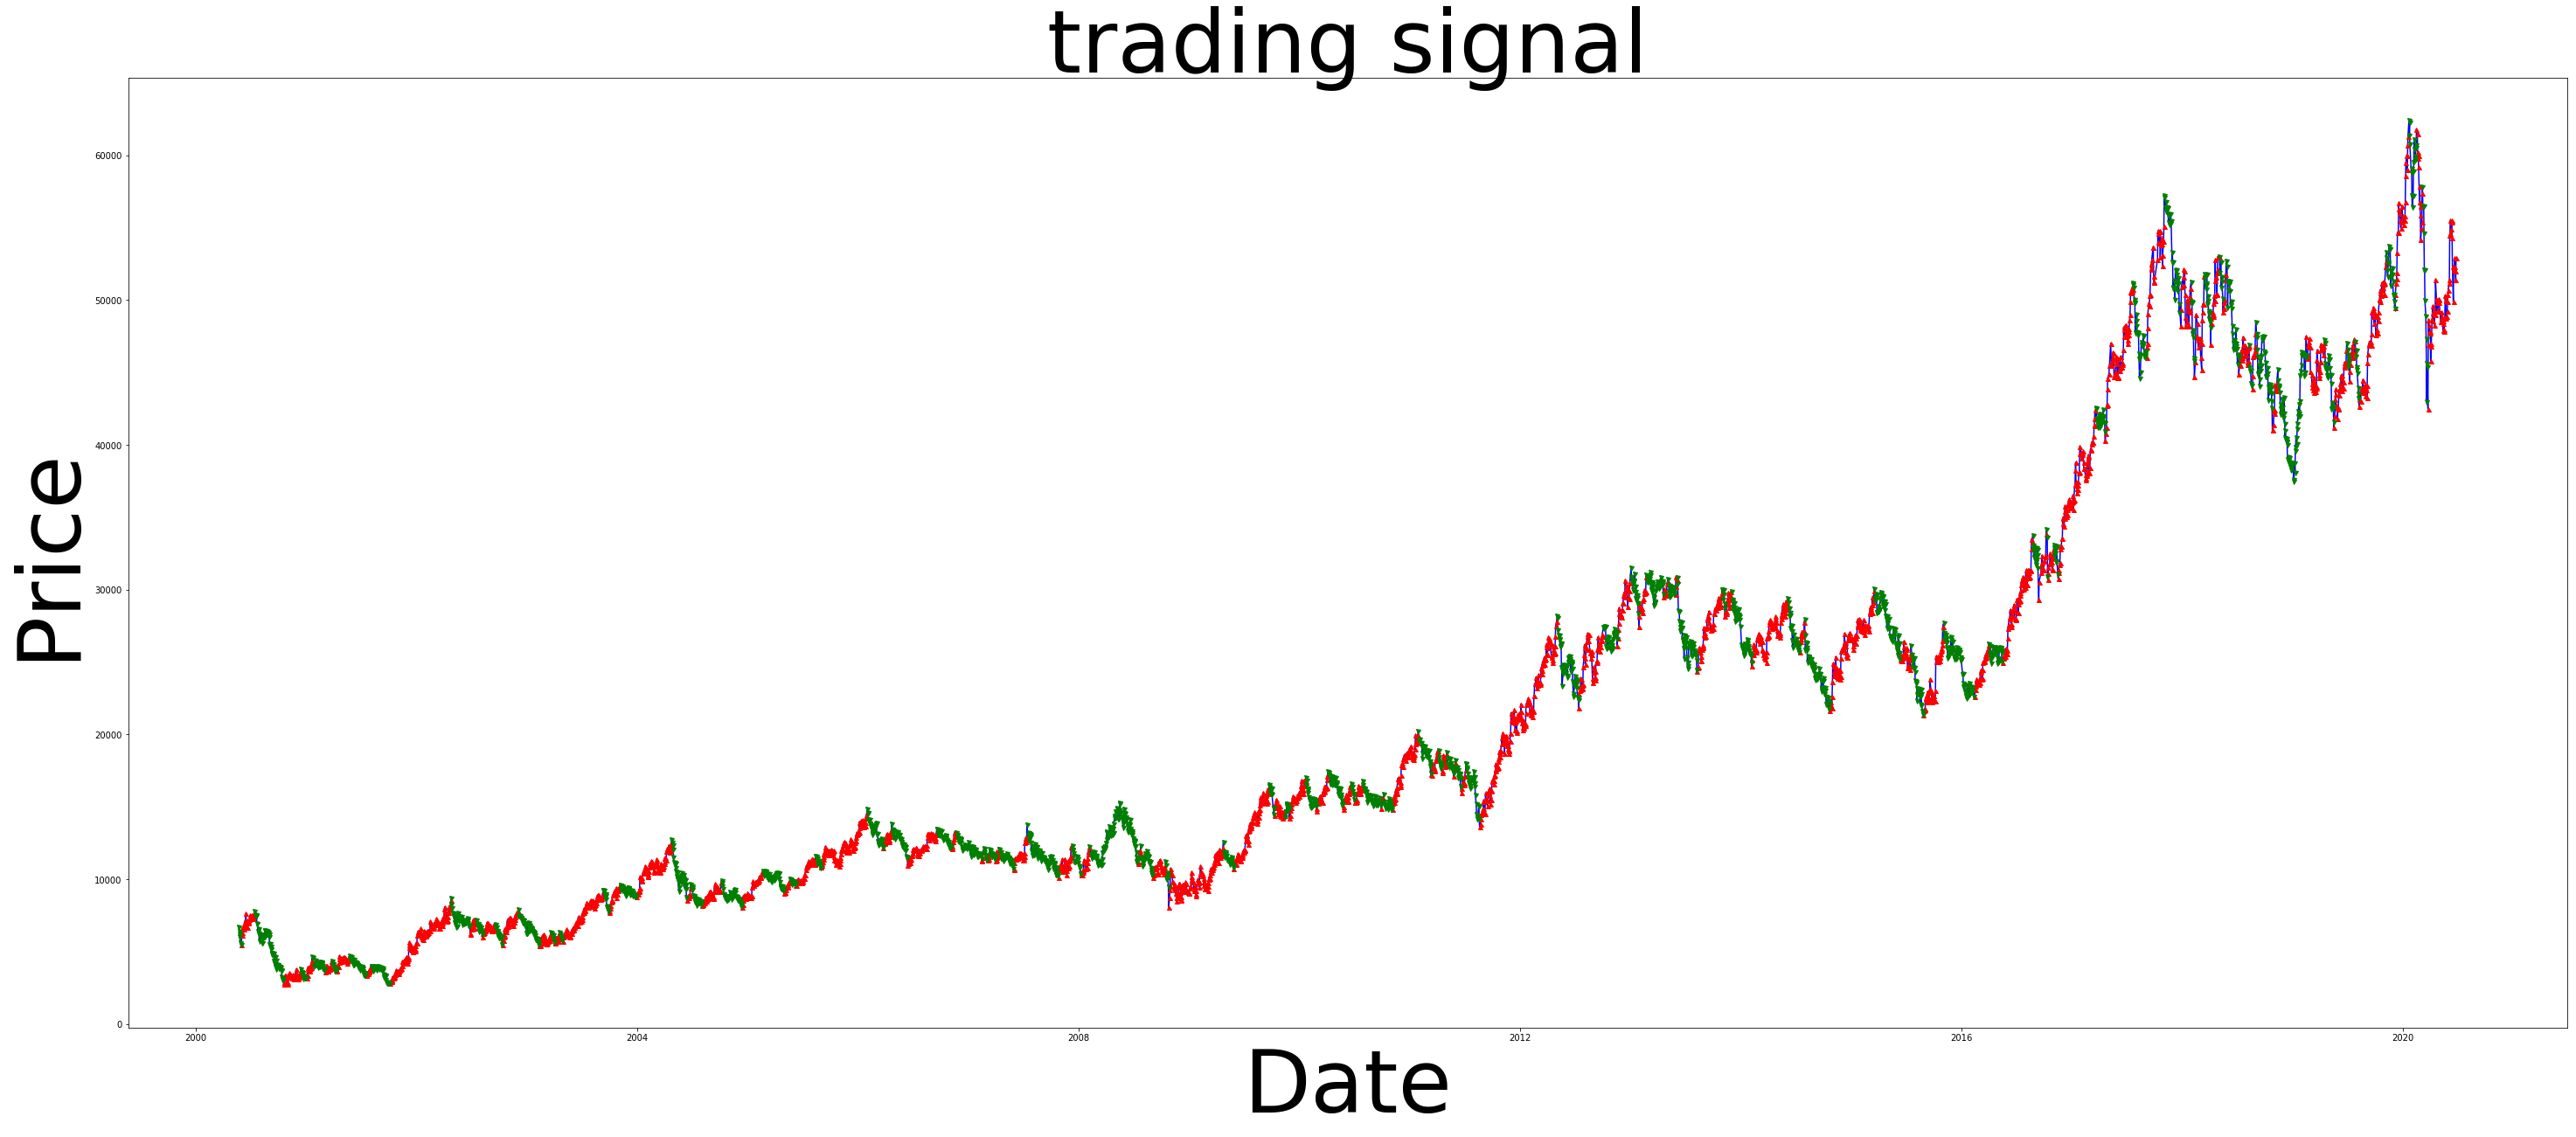

In [912]:
fig, ax1 = plt.subplots(figsize=(50,20))
plt.title('trading signal',size=100)
plt.xlabel('날짜', size=100)
plt.ylabel('close price',size=100)
ax1.plot(samsung.Date, samsung['Close'], label='Adj Close', color='b')
# Plot the buy and sell signals on the same plot
ax1.plot(up.Date, samsung.iloc[up.index]['Close'], '^', label='상승세' ,markersize=5, color='r' )
ax1.plot(down.Date, samsung.iloc[down.index]['Close'], 'v',label='하락세' ,markersize=5, color='g' )
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
# Display everything
plt.show()

In [913]:
samsung

,Date,High,Low,Open,Close,Volume,Adj Close,Target,Target_position,short_rolling,...,ema_short,RSI14,MACD,MACD_SIGN,MACD_HIST,slowk,slowd,WILLR,Open-Close,High-Low
0,2000-05-22,6830.0,6620.0,6720.0,6670.0,36385000.0,0.098903,0.642857,0.0,6298.5,...,6469.125311,55.257652,154.636388,90.246891,64.389497,44.742894,59.136789,-53.600000,50.0,210.0
1,2000-05-23,6700.0,6350.0,6500.0,6380.0,41290000.0,0.094603,0.785714,0.0,6335.5,...,6460.637186,49.387966,127.625512,97.722615,29.902897,27.673899,44.067637,-80.000000,120.0,350.0
2,2000-05-24,6370.0,5920.0,6160.0,6200.0,72150000.0,0.091934,0.928571,0.0,6365.5,...,6435.814597,46.113717,90.649749,96.308042,-5.658293,16.077779,29.498191,-80.281690,-40.0,450.0
3,2000-05-25,6380.0,5930.0,6330.0,6000.0,85965000.0,0.088968,0.785714,0.0,6395.5,...,6394.308445,42.724425,44.692672,85.984968,-41.292295,12.373165,18.708281,-94.366197,330.0,450.0
4,2000-05-26,5990.0,5600.0,5900.0,5600.0,67100000.0,0.083037,0.642857,0.0,6375.5,...,6318.660021,36.885311,-23.731734,64.041627,-87.773362,11.363064,13.271336,-100.000000,300.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,2020-06-18,52300.0,51600.0,52200.0,52300.0,15982926.0,52300.000000,0.214286,1.0,52197.5,...,52158.046643,52.159301,685.012276,954.855508,-269.843232,53.632479,32.717949,-66.197183,-100.0,700.0
5037,2020-06-19,52900.0,51600.0,52600.0,52900.0,18157985.0,52900.000000,0.285714,1.0,52405.0,...,52228.708867,54.567914,662.975292,896.479465,-233.504173,74.743590,51.780627,-57.746479,-300.0,1300.0
5038,2020-06-22,52600.0,51800.0,52000.0,52000.0,13801350.0,52000.000000,0.357143,1.0,52562.5,...,52206.927070,50.463748,566.359703,830.455512,-264.095810,80.289855,69.555308,-70.422535,0.0,800.0
5039,2020-06-23,52800.0,51100.0,52500.0,51400.0,18086152.0,51400.000000,0.428571,1.0,52670.0,...,52130.076873,47.878391,436.346239,751.633658,-315.287419,59.178744,71.404063,-78.873239,1100.0,1700.0


In [938]:
pd.set_option('max_rows', 5000)
def columnChg(x):
        if x==1: return 'up'
        elif x==0: return 'down'
        else: return 'down'

samsungSep = samsung.loc[X_test.index]
samsungSep['Trend_sign_int'] = knn.predict(X_test)
samsungSep["Trend_sign"] = samsungSep["Trend_sign_int"].apply(columnChg)

samsungSep

samsungSep.sort_values(by=['Date'])[['Date','Close','Trend_sign']]



,Date,Close,Trend_sign
8,2000-06-01,6300.0,up
12,2000-06-07,6800.0,down
17,2000-06-14,7640.0,up
19,2000-06-16,6740.0,up
23,2000-06-22,7040.0,up
26,2000-06-27,7310.0,up
29,2000-06-30,7380.0,up
33,2000-07-06,7300.0,up
43,2000-07-20,6900.0,down
45,2000-07-24,6380.0,down
